In [9]:
# Parameters
top_folder = "../data/top_collections"


In [10]:
%load_ext autoreload
%autoreload 2


import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,9)})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
df_t = pd.read_parquet(os.path.join(top_folder, 'asset_traits.parquet'), engine='pyarrow')
df_s = pd.read_parquet(os.path.join(top_folder, 'sales.parquet'), engine='pyarrow')
df_a = pd.read_parquet(os.path.join(top_folder, 'assets.parquet'), engine='pyarrow')



## Raw prices

<Axes: xlabel='timestamp', ylabel='price_eth'>

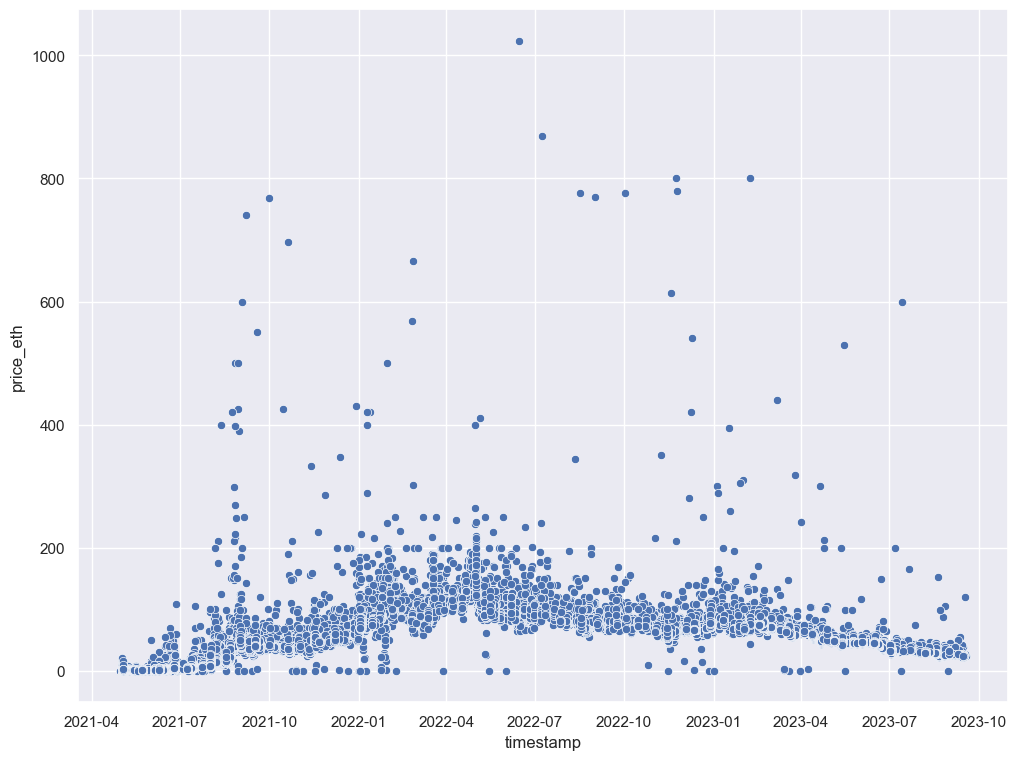

In [21]:
sns.scatterplot(data=df_s, x='timestamp', y='price_eth')

In [19]:
df_s = df_s.sort_values('timestamp')

window = 100

upper_outlier_threshold = 4
lower_outlier_threshold = 0.5


df_s[f'price_eth_trend_{window}'] = df_s['price_eth'].rolling(window, center=False) \
        .quantile(0.5).fillna(method='backfill').fillna(method='pad')

df_s[f'price_eth_scaled_{window}'] = df_s['price_eth'] / df_s[f'price_eth_trend_{window}'] * df_s[f'price_eth_trend_{window}'].iloc[-1]

df_s[f'price_eth_scaled_std_{window}'] = df_s[f'price_eth_scaled_{window}'].rolling(window, center=False) \
        .std().fillna(method='backfill').fillna(method='pad')


df_s[f'outlier'] = ((df_s['price_eth'] / df_s[f'price_eth_trend_{window}']) > upper_outlier_threshold ) | \
                     ((df_s['price_eth'] / df_s[f'price_eth_trend_{window}']) < lower_outlier_threshold )


df_s.to_parquet(os.path.join(top_folder, 'sales_with_trend.parquet'), engine='pyarrow')



# Price evolution and running median

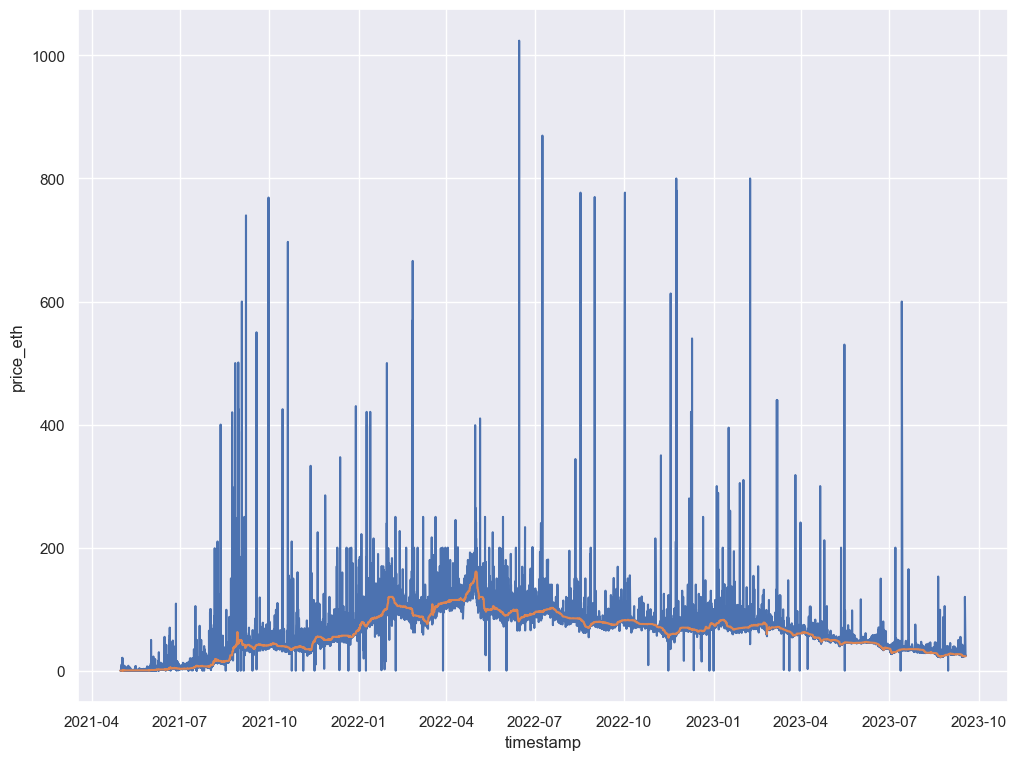

In [6]:
df_s2 = df_s.drop_duplicates(subset='timestamp').reset_index(drop=True).copy()

ax = sns.lineplot(data=df_s2, x='timestamp', y=f'price_eth')
ax = sns.lineplot(data=df_s2, x='timestamp', y=f'price_eth_trend_{window}')

# Prices scaled by rolling median to the current price

We want to find a relatively equal adjusted price distribution in the training and test sets.

[None]

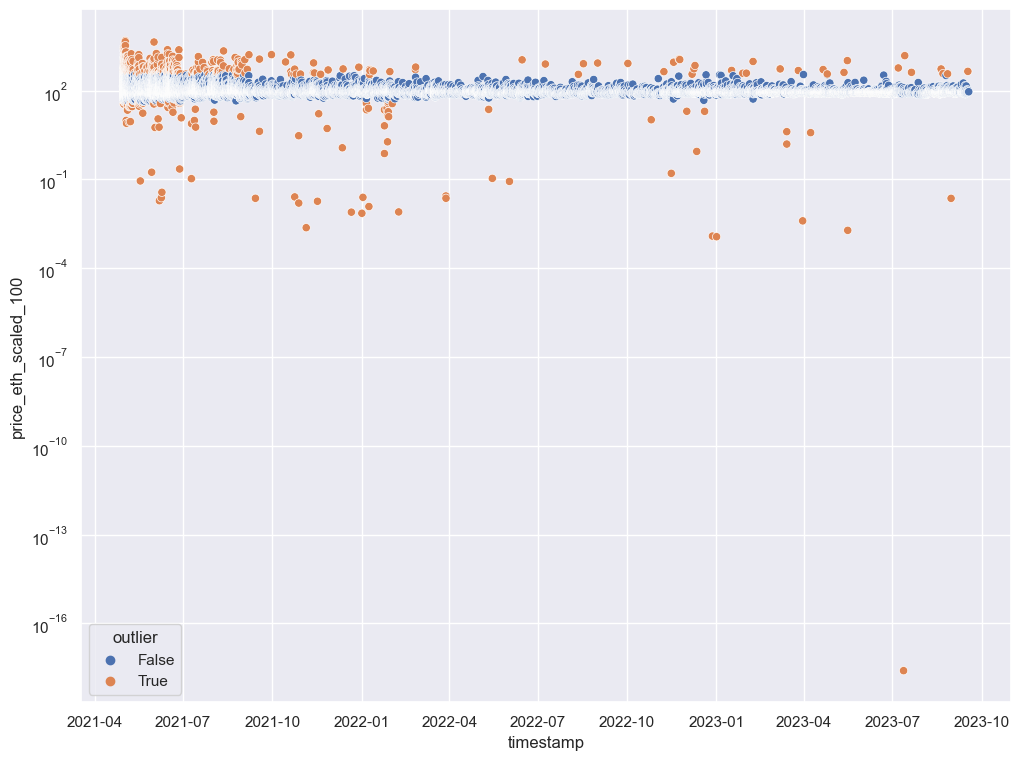

In [7]:
df_s2 = df_s.drop_duplicates(subset='timestamp').reset_index(drop=True).copy()

ax = sns.scatterplot(data=df_s2, x='timestamp', y='price_eth_scaled_100', hue='outlier')
ax.set(yscale="log")

# Rolling standart deviation of scaled prices

We want to find a relatively equal standart deviation in the training and test sets. We will use the rolling standart deviation of scaled prices to find the best split point.

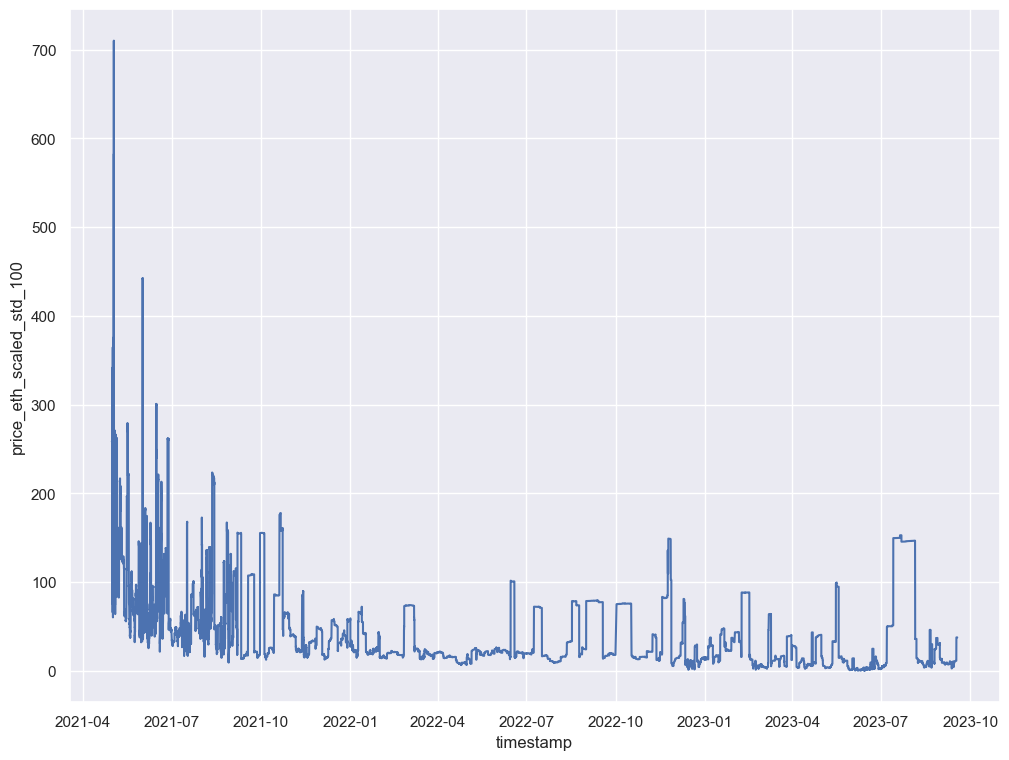

In [14]:
df_s2 = df_s.drop_duplicates(subset='timestamp').reset_index(drop=True).copy()

ax = sns.lineplot(data=df_s2, x='timestamp', y=f'price_eth_scaled_std_{window}')